---
title: Variational Autoencoders (VAEs)
author: Mark Fuge
date: 'October 12 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

# Variational Autoencoders (VAEs)

In the previous notebooks, we explored push-forward generative models (GANs) and then moved to optimal transport approaches. These models excel at generating samples by learning a mapping $f(z) \rightarrow x$ from latent space to data space. However, they have a significant limitation: they don't provide a way to go backwards -- to encode a real data point $x$ back into the latent space $z$.

**Variational Autoencoders (VAEs)** address this limitation by learning both directions simultaneously:

- An **encoder** that maps data to latent space: $q_\phi(z|x)$
- A **decoder** that maps latent space to data: $p_\theta(x|z)$

We saw this kind of encoder-decoder structure before when we discussed (non-variational) Autoencoders, but only in the context of deterministic mappings for dimension reduction. Now, we will extend this idea to probabilistic mappings that allow us to both generate new data and infer latent representations with explicit likelihoods.

## Learning Objectives

- Understand the architecture and motivation behind Variational Autoencoders
- Learn about the Evidence Lower Bound (ELBO) and why it's used for training
- Explore the role of the KL divergence regularization term
- Build and train a simple VAE on 2D data
- Visualize the learned latent space and understand the encoder-decoder relationship
- Compare VAEs to GANs and understand their respective strengths

In [1]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import List

# Optional interactive widgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    widgets_available = True
except Exception:
    interact = None
    FloatSlider = IntSlider = None
    widgets_available = False

# Import shared utilities from the local module
from gen_models_utilities import (
    device, create_ring_gaussians,
    make_loader, compute_diversity_metric, plot_model_diagnostics, plot_latent_interpolation
)

plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

print(f"Using device: {device}")

Using device: cuda


## What is a Variational Autoencoder?

To understand VAEs, let's start with regular **autoencoders**. An autoencoder is a neural network trained to compress data into a lower-dimensional representation (encoding) and then reconstruct the original data from that compressed form (decoding). The key insight is that if we can successfully compress and reconstruct data, the compressed representation must capture the essential features of the original dataset, in a possibly more interpretable form.

However, regular autoencoders have a problem: the latent space can be irregular and discontinuous. Two similar data points might end up far apart in latent space, making it hard to generate new samples or interpolate smoothly. This is not a problem as far as a regular Autoencoder is concerned, since its only goal in life is to reconstruct the training data well (it doesn't care about interpolation or what the latent space might mean).

**Variational Autoencoders** solve this by imposing structure on the latent space. Instead of encoding a data point $x$ to a single point $z$, a VAE encodes it to a **probability distribution** over $z$. This is typically a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$:

$$
q_\phi(z|x) = \mathcal{N}(z; \mu_\phi(x), \sigma_\phi^2(x))
$$

where $\phi$ represents the encoder parameters (typically those of a neural network).

The decoder then samples from this distribution to reconstruct the data:
$$p_\theta(x|z) = \mathcal{N}(x; \mu_\theta(z), \sigma_\theta^2(z))$$

where $\theta$ represents the decoder parameters.

With this, we actually have two types of probabilistic models, one that can compute the likelihood of a data point ($x$) given a latent code ($z$), and a second that can infer a distribution over latent codes ($z$) given a data point ($x$).

### The ELBO: Why VAEs Work

VAEs are trained by maximizing the **Evidence Lower Bound (ELBO)**, which decomposes into two terms:

$$
\text{ELBO} = \underbrace{\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]}_\text{Reconstruction term} - \underbrace{D_{KL}(q_\phi(z|x) \| p(z))}_\text{Regularization term}
$$

Let's break this down:

1. **Reconstruction term**: This measures how well the decoder can reconstruct the original data from the latent representation. It's similar to a standard autoencoder loss.

2. **KL divergence term**: This regularizes the latent space by encouraging $q_\phi(z|x)$ to be close to a prior distribution $p(z)$ (typically a standard normal $\mathcal{N}(0, I)$). This ensures the latent space is well-behaved and continuous.

The KL term has a nice closed-form solution when both distributions are Gaussian:

$$
D_{KL}(q_\phi(z|x) \| p(z)) = \frac{1}{2}\sum_{i=1}^{d} (\mu_i^2 + \sigma_i^2 - \log(\sigma_i^2) - 1)
$$

Let's step back a moment and think about what this term is encouraging. $p(z)$ is fixed, so the only thing we are changing when we optimize the KL divergence is $q_\phi$ (via the Neural Network weights $\phi$). What is $\phi$ trying to do? Given an $x$ from our training data, $\phi$ will transform it to $z$ using the encoder's neural network, and this will constitute a distribution over $z$ influenced by $x$, specifically, $z \sim \mathcal{N}(z; \mu_\phi(x), \sigma_\phi^2(x))$. So this will produce a tiny little Gaussian blob in $z$ for that given $x$, and the KL divergence will penalize this $q_\phi(z|x)$ from being "far" (in a KL sense) from $p(z)$. However, this doesn't mean that $q_\phi(z|x)$ will look at all like $p(z)$, rather, $p(z)$ is just sort of gently encouraging $q_\phi(z|x)$ to remaining close by to $p(z)$. In fact, $q_\phi(z|x)$ can't look too much like $p(z)$ because then $q_\phi(z|x)$ would be conditionally independent from $x$ and this would make it hard for the decoder ($p_\theta(x|z)$) to reproduce $x$ well.

### The Reparameterization Trick

To train VAEs with backpropagation, we need gradients to flow through the sampling operation. The **reparameterization trick** achieves this by rewriting the sampling as:

$$
z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Now the randomness is moved to $\epsilon$, and gradients can flow through $\mu$ and $\sigma$.

## Building a Simple VAE

Let's implement a VAE for our familiar 2D ring dataset. We'll keep the architecture simple so we can visualize and understand what's happening.

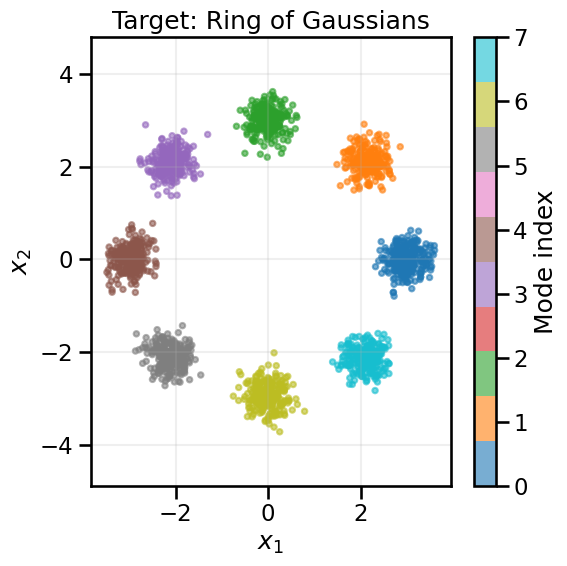

In [2]:
# Load the ring dataset
X_ring, y_ring = create_ring_gaussians(n_samples=2000)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc = ax.scatter(X_ring[:, 0], X_ring[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.6)
plt.colorbar(sc, label='Mode index')
ax.set_title('Target: Ring of Gaussians')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.axis('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### VAE Architecture

Our VAE will consist of two networks:

1. **Encoder**: Takes 2D data and outputs the parameters ($\mu$, $\log\sigma^2$) of a Gaussian distribution in latent space
2. **Decoder**: Takes a latent code $z$ and reconstructs the 2D data point

For this simple example, we'll use 2D latent space so we can visualize it directly.

In [3]:
#| code-fold: false
class Encoder(nn.Module):
    """Encoder network that maps data to latent distribution parameters."""
    def __init__(self, x_dim: int = 2, hidden_dim: int = 128, z_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Output mean and log-variance of the latent distribution
        self.mu_layer = nn.Linear(hidden_dim, z_dim)
        self.logvar_layer = nn.Linear(hidden_dim, z_dim)
    
    def forward(self, x: torch.Tensor):
        h = self.net(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar


class Decoder(nn.Module):
    """Decoder network that maps latent codes back to data space."""
    def __init__(self, z_dim: int = 2, hidden_dim: int = 128, x_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim)
        )
    
    def forward(self, z: torch.Tensor):
        return self.net(z)


class VAE(nn.Module):
    """Variational Autoencoder combining encoder and decoder."""
    def __init__(self, x_dim: int = 2, z_dim: int = 2, hidden_dim: int = 128):
        super().__init__()
        self.encoder = Encoder(x_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, x_dim)
        self.z_dim = z_dim
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor):
        """Reparameterization trick: z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x: torch.Tensor):
        # Encode
        mu, logvar = self.encoder(x)
        # Sample from latent distribution
        z = self.reparameterize(mu, logvar)
        # Decode
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z
    
    def encode(self, x: torch.Tensor):
        """Encode data to latent space (returns mean of distribution)."""
        mu, _ = self.encoder(x)
        return mu
    
    def decode(self, z: torch.Tensor):
        """Decode latent codes to data space."""
        return self.decoder(z)

### The VAE Loss Function

The VAE loss combines reconstruction error and KL divergence. For reconstruction, we'll use mean squared error (MSE), which corresponds to assuming a Gaussian likelihood with a mean at the decoder value ($\hat{x} = \mu_\theta(z)$) and a variance $\sigma_\theta^2$ that could be output by the decoder:

$$
\mathcal{L} = \underbrace{\frac{1}{2\sigma_\theta^2}\|x - \hat{x}\|^2}_\text{Reconstruction} + \underbrace{D_{KL}(q_\phi(z|x) \| p(z))}_\text{KL divergence}
$$

In a simplified case, we could set $\sigma_\theta^2$ to be a constant value ($\sigma^2$) in which case the only job of the decoder would be to output a single vector (the mean value $\hat{x} = \mu_\theta(z)$) and then the constant $\sigma^2$ would effectively control the trade-off between reconstruction accuracy and regularization strength.

In [4]:
#| code-fold: false
def vae_loss(x: torch.Tensor, x_recon: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, 
             beta: float = 1.0, reconstruction_variance: float = 0.1):
    """
    Compute VAE loss = Reconstruction loss + beta * KL divergence.
    
    Args:
        x: Original data
        x_recon: Reconstructed data
        mu: Mean of latent distribution
        logvar: Log-variance of latent distribution
        beta: Weight for KL term (beta=1 is standard VAE, beta>1 is beta-VAE)
        reconstruction_variance: Assumed variance of reconstruction distribution
    """
    # Reconstruction loss (MSE scaled by assumed variance)
    recon_loss = torch.sum((x - x_recon) ** 2, dim=1) / (2 * reconstruction_variance)
    
    # KL divergence between q(z|x) and p(z) = N(0,I)
    # KL(N(mu, sigma^2) || N(0,1)) = 0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    # Total loss (negative ELBO)
    return (recon_loss + beta * kl_div).mean(), recon_loss.mean(), kl_div.mean()

### Training the VAE

Now let's train our VAE on the ring dataset. We'll track both the reconstruction loss and KL divergence separately to understand how the model learns.

In [5]:
#| code-fold: false
@dataclass
class VAEHistory:
    """Training history for VAE."""
    loss: List[float]
    recon_loss: List[float]
    kl_loss: List[float]
    diversity: List[float]


def train_vae(
    data: np.ndarray,
    x_dim: int = 2,
    z_dim: int = 2,
    hidden_dim: int = 128,
    batch_size: int = 256,
    epochs: int = 200,
    lr: float = 1e-3,
    beta: float = 1.0,
    reconstruction_variance: float = 0.1,
    print_every: int = 50
):
    """
    Train a VAE on the provided data.
    
    Args:
        data: Training data (numpy array)
        x_dim: Dimension of data space
        z_dim: Dimension of latent space
        hidden_dim: Hidden layer dimension
        batch_size: Batch size for training
        epochs: Number of training epochs
        lr: Learning rate
        beta: Weight for KL term (beta-VAE parameter)
        reconstruction_variance: Assumed variance of reconstruction distribution
        print_every: Print progress every N epochs
    
    Returns:
        Trained VAE model and training history
    """
    # Setup data loader
    loader = make_loader(data, batch_size)
    
    # Initialize model and optimizer
    vae = VAE(x_dim=x_dim, z_dim=z_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    
    # Training history
    history = VAEHistory(loss=[], recon_loss=[], kl_loss=[], diversity=[])
    
    print(f"Training VAE for {epochs} epochs...")
    print(f"Parameters: z_dim={z_dim}, beta={beta}, recon_var={reconstruction_variance}, lr={lr}")
    
    vae.train()
    for epoch in range(epochs):
        epoch_losses = []
        epoch_recon = []
        epoch_kl = []
        
        for (batch,) in loader:
            batch = batch.to(device)
            
            # Forward pass
            x_recon, mu, logvar, z = vae(batch)
            
            # Compute loss
            loss, recon, kl = vae_loss(batch, x_recon, mu, logvar, beta, reconstruction_variance)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            epoch_recon.append(recon.item())
            epoch_kl.append(kl.item())
        
        # Record metrics
        mean_loss = np.mean(epoch_losses)
        mean_recon = np.mean(epoch_recon)
        mean_kl = np.mean(epoch_kl)
        
        # Compute diversity (sample from prior and decode)
        with torch.no_grad():
            z_samples = torch.randn(2048, z_dim, device=device)
            x_samples = vae.decode(z_samples)
            diversity = compute_diversity_metric(x_samples)
        
        history.loss.append(mean_loss)
        history.recon_loss.append(mean_recon)
        history.kl_loss.append(mean_kl)
        history.diversity.append(diversity)
        
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Loss: {mean_loss:.3f} | "
                  f"Recon: {mean_recon:.3f} | KL: {mean_kl:.3f} | Div: {diversity:.3f}")
    return vae, history

In [6]:
# Train the VAE
vae, history = train_vae(
    X_ring,
    x_dim=2,
    z_dim=2,
    hidden_dim=128,
    epochs=400,
    batch_size=256,
    lr=1e-3,
    beta=1.0,
    reconstruction_variance=0.1,
    print_every=50
)

Training VAE for 400 epochs...
Parameters: z_dim=2, beta=1.0, recon_var=0.1, lr=0.001
Epoch 001/400 | Loss: 43.550 | Recon: 43.310 | KL: 0.240 | Div: 0.074
Epoch 001/400 | Loss: 43.550 | Recon: 43.310 | KL: 0.240 | Div: 0.074
Epoch 050/400 | Loss: 4.296 | Recon: 0.964 | KL: 3.332 | Div: 3.860
Epoch 050/400 | Loss: 4.296 | Recon: 0.964 | KL: 3.332 | Div: 3.860
Epoch 100/400 | Loss: 3.996 | Recon: 0.917 | KL: 3.079 | Div: 3.879
Epoch 100/400 | Loss: 3.996 | Recon: 0.917 | KL: 3.079 | Div: 3.879
Epoch 150/400 | Loss: 3.904 | Recon: 0.842 | KL: 3.062 | Div: 3.965
Epoch 150/400 | Loss: 3.904 | Recon: 0.842 | KL: 3.062 | Div: 3.965
Epoch 200/400 | Loss: 3.813 | Recon: 0.813 | KL: 3.001 | Div: 4.029
Epoch 200/400 | Loss: 3.813 | Recon: 0.813 | KL: 3.001 | Div: 4.029
Epoch 250/400 | Loss: 3.797 | Recon: 0.986 | KL: 2.810 | Div: 4.013
Epoch 250/400 | Loss: 3.797 | Recon: 0.986 | KL: 2.810 | Div: 4.013
Epoch 300/400 | Loss: 3.734 | Recon: 0.822 | KL: 2.912 | Div: 4.059
Epoch 300/400 | Loss: 3.73

### Visualizing Training Progress

Let's look at how the different loss components evolved during training:

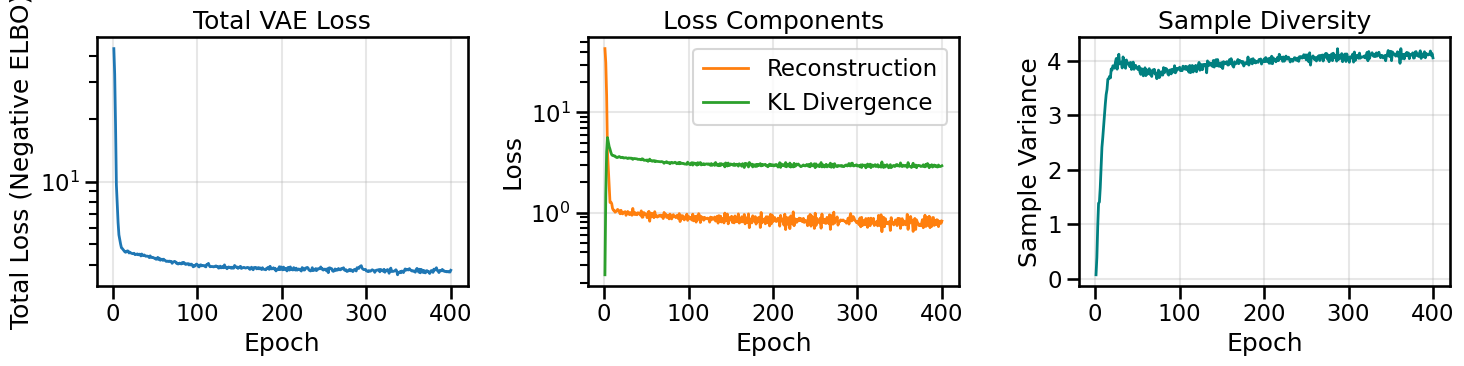

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = np.arange(1, len(history.loss) + 1)

# Total loss
axes[0].plot(epochs, history.loss, color='tab:blue', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss (Negative ELBO)')
axes[0].set_title('Total VAE Loss')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Reconstruction vs KL
axes[1].plot(epochs, history.recon_loss, label='Reconstruction', linewidth=2, color='tab:orange')
axes[1].plot(epochs, history.kl_loss, label='KL Divergence', linewidth=2, color='tab:green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Components')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Diversity
axes[2].plot(epochs, history.diversity, color='teal', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Sample Variance')
axes[2].set_title('Sample Diversity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exploring the Learned Latent Space

One of the most powerful aspects of VAEs is that we can visualize the latent space directly (since we're using 2D latent codes). Let's see how the VAE has organized the ring data in latent space.

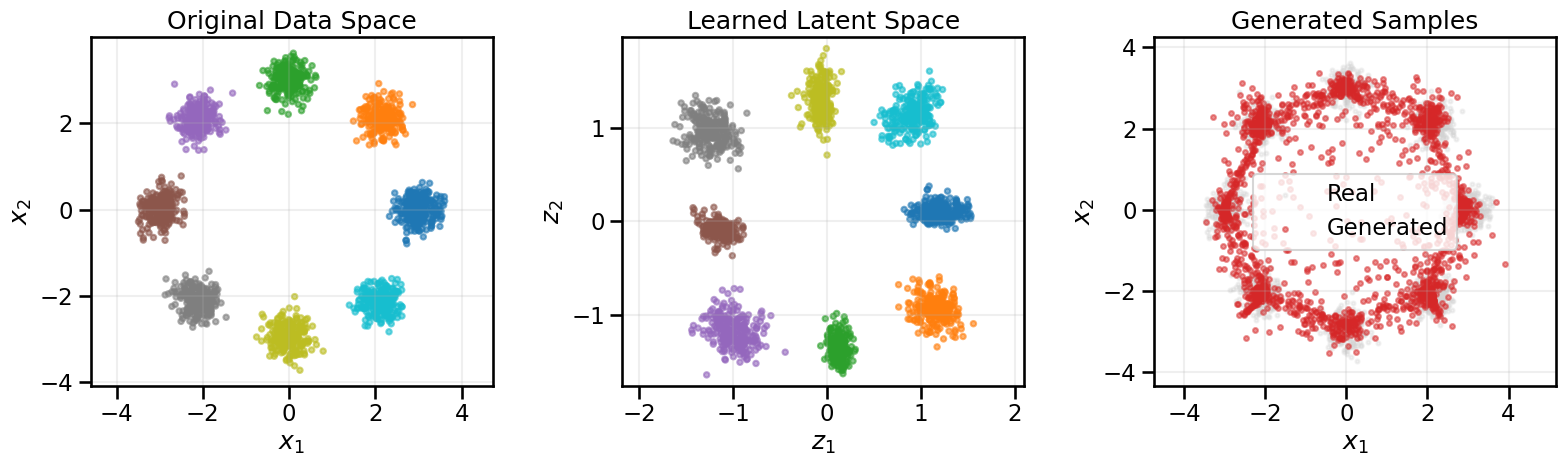

In [8]:
# Encode all data points to latent space
vae.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_ring).float().to(device)
    z_encoded = vae.encode(X_tensor).cpu().numpy()
    
    # Generate samples from prior
    z_prior = torch.randn(2000, 2, device=device)
    x_generated = vae.decode(z_prior).cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original data space
sc0 = axes[0].scatter(X_ring[:, 0], X_ring[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.6)
axes[0].set_title('Original Data Space')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)

# Latent space (colored by original mode)
sc1 = axes[1].scatter(z_encoded[:, 0], z_encoded[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.6)
axes[1].set_title('Learned Latent Space')
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)

# Generated samples
axes[2].scatter(X_ring[:, 0], X_ring[:, 1], c='lightgray', s=8, alpha=0.3, label='Real')
axes[2].scatter(x_generated[:, 0], x_generated[:, 1], c='tab:red', s=12, alpha=0.5, label='Generated')
axes[2].set_title('Generated Samples')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.2)
axes[2].legend()

plt.tight_layout()
plt.show()

### Visualizing $q_\phi(z|x)$

The encoder learns to map each input data point $x$ to a *distribution* in the latent space, not just a single point. Let's pick two points from our dataset and visualize the corresponding Gaussian distributions $q_\phi(z|x)$ that the encoder has learned for them.

In [9]:
#| code-fold: false
# Select two points from the dataset
point_1_idx, point_2_idx = 150, 1050
x_1 = torch.from_numpy(X_ring[point_1_idx]).float().to(device)
x_2 = torch.from_numpy(X_ring[point_2_idx]).float().to(device)

# Get the parameters of q(z|x) for these two points
vae.eval()
with torch.no_grad():
    mu_1, logvar_1 = vae.encoder(x_1.unsqueeze(0))
    mu_2, logvar_2 = vae.encoder(x_2.unsqueeze(0))

# Create distributions
std_1 = torch.exp(0.5 * logvar_1)
dist_1 = torch.distributions.MultivariateNormal(mu_1.squeeze(), torch.diag(std_1.squeeze().pow(2)))

std_2 = torch.exp(0.5 * logvar_2)
dist_2 = torch.distributions.MultivariateNormal(mu_2.squeeze(), torch.diag(std_2.squeeze().pow(2)))

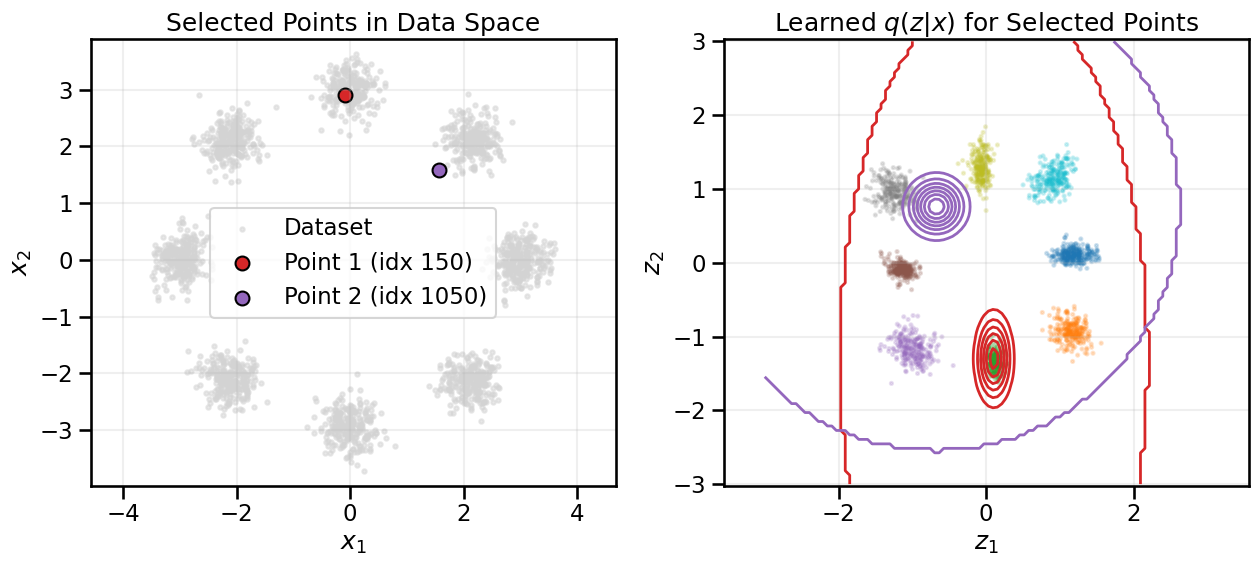

In [10]:

# Create a grid for the latent space plot
z_range = 3.0
z_grid_pts = 100
z1_grid = torch.linspace(-z_range, z_range, z_grid_pts, device=device)
z2_grid = torch.linspace(-z_range, z_range, z_grid_pts, device=device)
Z1, Z2 = torch.meshgrid(z1_grid, z2_grid, indexing='xy')
z_grid_tensor = torch.stack([Z1.flatten(), Z2.flatten()], dim=1)

# Evaluate densities on the grid
log_prob_1 = dist_1.log_prob(z_grid_tensor)
log_prob_2 = dist_2.log_prob(z_grid_tensor)
prob_1 = log_prob_1.exp().reshape(z_grid_pts, z_grid_pts).cpu().numpy()
prob_2 = log_prob_2.exp().reshape(z_grid_pts, z_grid_pts).cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
color1, color2 = 'tab:red', 'tab:purple'

# Left plot: Original data space
axes[0].scatter(X_ring[:, 0], X_ring[:, 1], c='lightgray', s=10, alpha=0.5, label='Dataset')
axes[0].scatter(x_1[0].cpu(), x_1[1].cpu(), color=color1, s=100, ec='black', label=f'Point 1 (idx {point_1_idx})')
axes[0].scatter(x_2[0].cpu(), x_2[1].cpu(), color=color2, s=100, ec='black', label=f'Point 2 (idx {point_2_idx})')
axes[0].set_title('Selected Points in Data Space')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)
axes[0].legend()

# Right plot: Latent space distributions
axes[1].contour(Z1.cpu().numpy(), Z2.cpu().numpy(), prob_1, colors=color1, linewidths=2)
axes[1].contour(Z2.cpu().numpy(), Z1.cpu().numpy(), prob_2, colors=color2, linewidths=2)
# Also plot the full latent space encoding for context
axes[1].scatter(z_encoded[:, 0], z_encoded[:, 1], c=y_ring, cmap='tab10', s=5, alpha=0.2)
axes[1].set_title('Learned $q(z|x)$ for Selected Points')
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Visualizing the Latent Space Manifold

Since both our data and latent space are 2D, we can create a grid in latent space and see what the decoder produces at each point. This helps us understand how the VAE has organized the latent space.

In [11]:
#| code-fold: false
# Create a grid in latent space
n_points = 20
z_range = 2.0
z1 = np.linspace(-z_range, z_range, n_points)
z2 = np.linspace(-z_range, z_range, n_points)
Z1, Z2 = np.meshgrid(z1, z2)
z_grid = np.stack([Z1.flatten(), Z2.flatten()], axis=1).astype(np.float32)

# Decode the grid
with torch.no_grad():
    z_grid_tensor = torch.from_numpy(z_grid).to(device)
    x_grid = vae.decode(z_grid_tensor).cpu().numpy()

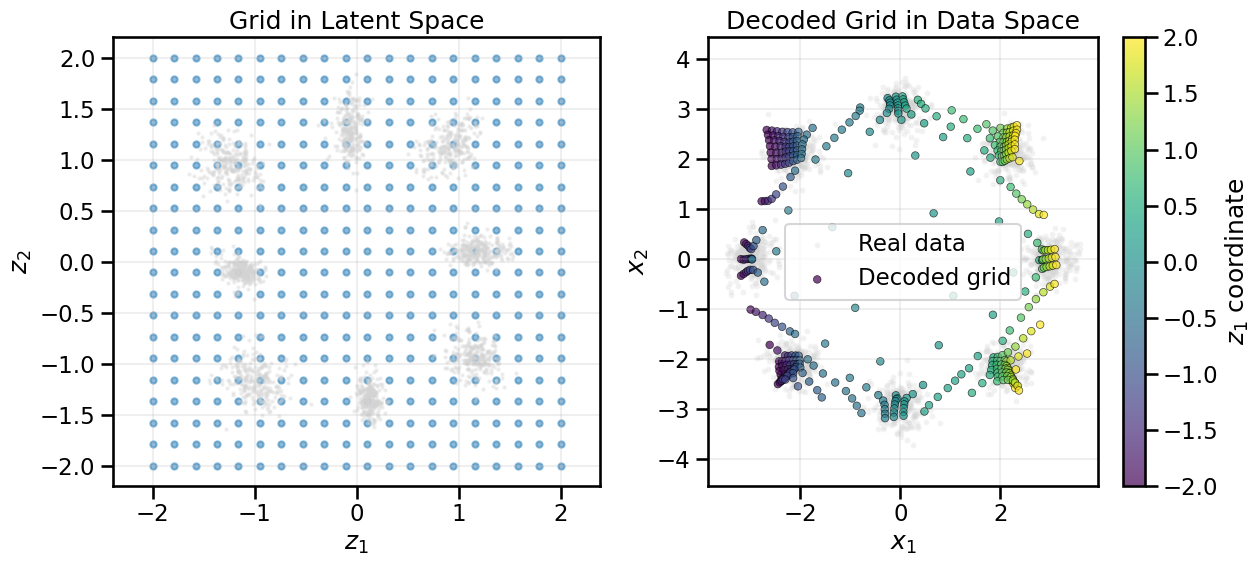

In [12]:

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Latent space grid
axes[0].scatter(z_grid[:, 0], z_grid[:, 1], c='tab:blue', s=20, alpha=0.5)
axes[0].scatter(z_encoded[:, 0], z_encoded[:, 1], c='lightgray', s=3, alpha=0.3)
axes[0].set_title('Grid in Latent Space')
axes[0].set_xlabel('$z_1$')
axes[0].set_ylabel('$z_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)

# Corresponding points in data space
axes[1].scatter(X_ring[:, 0], X_ring[:, 1], c='lightgray', s=8, alpha=0.2, label='Real data')
sc = axes[1].scatter(x_grid[:, 0], x_grid[:, 1], c=z_grid[:, 0], cmap='viridis', s=30, alpha=0.7, 
                     edgecolors='black', linewidths=0.5, label='Decoded grid')
plt.colorbar(sc, ax=axes[1], label='$z_1$ coordinate')
axes[1].set_title('Decoded Grid in Data Space')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

::: {.callout-tip appearance="default"}
### Experiment: Effect of re-weighting the KL Divergence term

We can see above that `reconstruction_variance` essentially sets the variances of the Gaussian outputs for the reconstructed data points.
- Mathematically, what does setting this to a small variance imply for the loss function? What about a big variance?
- Try modifying the `reconstruction_variance` above from a small number to a large one, e.g., 0.01 to 5.0. What happens to the output of the VAE? Why is this? (Note: if you go below about 0.1 then you may have to increase the learning rate of number of epochs unless it converges.)

:::

## Comparing VAEs to GANs and OT Models

Now that we understand VAEs, let's compare them to the other generative models we've studied:

| Aspect | GAN | OT GAN | VAE |
|--------|-----|--------|-----|
| **Architecture** | Generator + Discriminator | Generator only | Encoder + Decoder |
| **Training** | Adversarial (minimax) | Direct divergence minimization | Maximize ELBO |
| **Stability** | Can be unstable | More stable | Generally stable |
| **Forward map** | Yes ($z \rightarrow x$) | Yes ($z \rightarrow x$) | Yes ($z \rightarrow x$) |
| **Inverse map** | No | No | Yes ($x \rightarrow z$) |
| **Mode coverage** | Prone to mode collapse | Good coverage | Good coverage |
| **Interpretability** | Limited | Limited | Good (latent space mirrors $p(z)$) |

### When to use VAEs:

1. **When you need an encoder**: If you want to map real data to latent codes (for analysis, interpolation, or compression)
2. **For smooth interpolation**: The regularized latent space makes interpolation meaningful
3. **When interpretability matters**: VAEs often learn more interpretable latent representations
4. **When training stability is important**: VAEs are generally easier to train than GANs

### When to use GANs or OT models:

1. **When sample quality is paramount**: GANs often produce sharper, more realistic samples
2. **When you only need generation**: If you don't need to encode real data
3. **For specific domains**: GANs can excel at images, videos, and other perceptual data compared to VAEs (at least historically)

## Summary and Looking Forward

In this notebook, we explored Variational Autoencoders (VAEs), which provide a principled approach to learning bidirectional mappings between data and latent space:

### Key Takeaways:

1. **VAEs learn distributions**: Unlike deterministic autoencoders, VAEs encode data as distributions in latent space, enabling smooth interpolation and principled sampling.

2. **The ELBO objective**: VAEs maximize a lower bound on the data likelihood, balancing reconstruction accuracy with latent space regularization.

3. **KL divergence regularization**: This term ensures the latent space is well-behaved (close to a standard normal), making sampling and interpolation meaningful.

4. **Bidirectional mapping**: VAEs provide both encoding ($x \rightarrow z$) and decoding ($z \rightarrow x$), enabling applications like representation learning and data analysis.

### Limitations and Extensions:

While VAEs are powerful, they have some limitations:
- **Blurry samples**: The MSE reconstruction loss can lead to averaged, blurry outputs
- **Posterior collapse**: In high dimensions, the KL term can dominate, causing the model to ignore the encoder
- **Limited expressiveness**: The Gaussian assumption may be too restrictive for complex distributions

Modern extensions address these issues (not covered here):
- **β-VAE**: Adjustable β for better disentanglement
- **Normalizing Flow VAEs**: Use more expressive posterior distributions
- **Vector Quantized VAEs (VQ-VAE)**: Discrete latent codes for sharper reconstructions
- **Hierarchical VAEs**: Multiple layers of latent variables for richer representations

### Next Steps:

VAEs created an important step beyond GAN models in that they allowed us to model probability distributions over both the output data samples from the generator $p_\theta(z|x)$ but also the possible latent codes via an encoder $q_\phi(z|x)$. However, the VAE was only able to predict the latent codes using an approximation method (variational inference) by assuming a $q$ and minimizing the ELBO.

What if it were possible to learn both $p(x|z)$ and $q(z|x)$ exactly? In the next notebook, we'll explore **Normalizing Flows**, which provide another way to learn bidirectional mappings with *exact* likelihood computation. Unlike VAEs, flows are deterministic and invertible, allowing for exact inference without variational approximations. This makes them particularly useful when we need precise likelihood estimates or want to avoid the approximation errors inherent in VAEs.